In [29]:
import os
import math
import json
import datetime
import numpy as np
import pandas as pd

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import levene
from scipy.ndimage import center_of_mass

def plane(X, a, b, c):
    '''equation for a plane for approximating background subtractions in cropped microscope images'''
    return(a*X[0] + b * X[1] + c)


class simpleStimData:
    '''
    class for interpreting data saved on the microscope during live-cell tracking and computer-
    generated opto experiments. Contains information about the state of the microscope, the images
    themselves, and has methods for background subtraction and some basic processing
    '''
    def __init__(self, folderpath):
        self.folderpath = folderpath
        self.xpath_rot = []
        self.ypath_rot = []
        self.assay_type = ''
        self.get_image_paths()
        self.get_stage_data()
        self.transform_mats = self.get_transformation_matrices()
        self.get_image_stacks()
        self.background_subtraction()
        
    def get_image_paths(self):
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([self.folderpath + '/' + i for i in np.sort(os.listdir(self.folderpath))])
        except:
            im_path_list = np.sort([self.folderpath + '/' + i.decode('ascii') for i in np.sort(os.listdir(self.folderpath))])

        self.ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        self.ch1_path_list = np.sort([i for i in im_path_list if 'channel001' in i])
        self.ch2_path_list = np.sort([i for i in im_path_list if 'channel002' in i])
        self.ch3_path_list = np.sort([i for i in im_path_list if 'channel003' in i])
        self.ch4_path_list = np.sort([i for i in im_path_list if 'channel004' in i])
        self.ch5_path_list = np.sort([i for i in im_path_list if 'channel005' in i])
        self.ch6_path_list = np.sort([i for i in im_path_list if 'channel006' in i])
        
    def get_stage_data(self):
        
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:

                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        # convert to numpy arrays to make translation and rotation a little easier
        self.x_stage_sequence = np.array(x_stage_sequence)
        self.y_stage_sequence = np.array(y_stage_sequence)

        # center paths on the moment of stimulation
        x_translated = self.x_stage_sequence - self.x_stage_sequence[10] 
        y_translated = self.y_stage_sequence - self.y_stage_sequence[10]

        # calculate the initial direction of the cell in the first ten frames
        self.theta = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - self.theta  + math.pi/2

        self.x_rotated = rho * np.cos(phi)
        self.y_rotated = rho * np.sin(phi)
        self.centering_x = self.x_stage_sequence[10]
        self.centering_y = self.y_stage_sequence[10]
        

    def get_transformation_matrices(self):
        
        temptif = tifffile.TiffFile(self.ch0_path_list[0])
        centering_matrix = np.array([[1, 0, -200],[0, 1, -200],[0, 0, 1]])
        affine_matrix = np.vstack([np.array([float(i) for i in temptif.shaped_metadata[0]['PixelSizeAffine'].split(';')]).reshape(2, 3), np.array([0, 0, 1])])
        rotation_matrix = np.array([[np.cos(self.theta), -np.sin(self.theta), 0], [np.sin(self.theta), np.cos(self.theta), 0], [0, 0, 1]])
        transformation_matrix = np.matmul(affine_matrix, centering_matrix)
        transformation_matrix = np.matmul(rotation_matrix, transformation_matrix)


        transformation_matrices = []
        for t in range(len(self.x_stage_sequence)):

            xt = (self.x_stage_sequence[t] - self.centering_x)
            yt = (self.y_stage_sequence[t] - self.centering_y)

            xr, yr, placeholder = np.matmul(rotation_matrix, np.array([xt, yt, 0]))
            translation_matrix = np.array([[1, 0, xr],[0, 1, yr],[0, 0, 1]])

            tm = np.matmul(translation_matrix, transformation_matrix)

            transformation_matrices.append(tm.copy())

        return(transformation_matrices)

        
    def get_image_stacks(self):
        
        # make some containers for the pixel intensity information
        self.ch0_stack = np.zeros((len(self.ch0_path_list), 400, 400))
        self.ch1_stack = np.zeros((len(self.ch1_path_list), 400, 400))
        self.ch2_stack = np.zeros((len(self.ch2_path_list), 400, 400))
        self.ch3_stack = np.zeros((len(self.ch3_path_list), 400, 400))
        self.ch4_stack = np.zeros((len(self.ch4_path_list), 400, 400))
        self.ch5_stack = np.zeros((len(self.ch5_path_list), 400, 400))
        self.ch6_stack = np.zeros((len(self.ch6_path_list), 400, 400))
        
        # and for elapsed time
        self.ch0_times = np.zeros(len(self.ch0_path_list))
        self.ch1_times = np.zeros(len(self.ch1_path_list))
        self.ch2_times = np.zeros(len(self.ch2_path_list))
        self.ch3_times = np.zeros(len(self.ch3_path_list))
        self.ch4_times = np.zeros(len(self.ch4_path_list))
        self.ch5_times = np.zeros(len(self.ch5_path_list))
        self.ch6_times = np.zeros(len(self.ch6_path_list))
        
        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:
                self.ch0_stack[i] = temptif.asarray()
                try:
                    self.ch0_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass

        for i in range(len(self.ch1_path_list)):
            with tifffile.TiffFile(self.ch1_path_list[i]) as temptif:
                self.ch1_stack[i] = temptif.asarray()
                try:
                    self.ch1_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch2_path_list)):
            with tifffile.TiffFile(self.ch2_path_list[i]) as temptif:
                self.ch2_stack[i] = temptif.asarray()
                try:
                    self.ch2_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch3_path_list)):
            with tifffile.TiffFile(self.ch3_path_list[i]) as temptif:
                self.ch3_stack[i] = temptif.asarray()
                try:
                    self.ch3_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch4_path_list)):
            with tifffile.TiffFile(self.ch4_path_list[i]) as temptif:
                self.ch4_stack[i] = temptif.asarray()
                try:
                    self.ch4_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch5_path_list)):
            with tifffile.TiffFile(self.ch5_path_list[i]) as temptif:
                self.ch5_stack[i] = temptif.asarray()
                try:
                    self.ch5_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch6_path_list)):
            with tifffile.TiffFile(self.ch6_path_list[i]) as temptif:
                self.ch6_stack[i] = temptif.asarray()
                try:
                    self.ch6_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
        
        
    def get_transformed_xy_coords(self, timepoint):
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz = np.ones_like(xx)

        coords = np.array([xx.ravel(), yy.ravel(), zz.ravel()])
        y_um, x_um, placeholder = np.matmul(self.transform_mats[timepoint], coords)
        
        return(x_um.reshape(400,400), y_um.reshape(400,400))

    
    def background_subtraction(self):
        # fit a plane to the median of non-cell signal over the course of the experiment
        bgstack_ch0 = []
        bgstack_ch1 = []
        for T in range(len(self.ch0_stack)):
            bg_ch0 = self.ch0_stack[T].copy()
            bg_ch1 = self.ch1_stack[T].copy()
            cell = self.ch3_stack[T] == 1
            cell = morphology.binary_dilation(cell, selem = morphology.disk(10))
            bg_ch0[cell] = np.nan
            bg_ch1[cell] = np.nan
            bgstack_ch0.append(bg_ch0)
            bgstack_ch1.append(bg_ch1)

        measured_bg_ch0 = np.nanmedian(bgstack_ch0, axis = 0)
        measured_bg_ch1 = np.nanmedian(bgstack_ch1, axis = 0)
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz_ch0 = measured_bg_ch0
        zz_ch1 = measured_bg_ch1

        xx = xx[np.isfinite(zz_ch0)]
        yy = yy[np.isfinite(zz_ch0)]
        zz_ch0 = zz_ch0[np.isfinite(zz_ch0)]
        zz_ch1 = zz_ch1[np.isfinite(zz_ch1)]

        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(plane, X, zz_ch0, p0 = [1, 1, 500])
        popt_ch1, pcov = optimize.curve_fit(plane, X, zz_ch1, p0 = [1, 1, 500])
        
        X = np.meshgrid(np.arange(400), np.arange(400))
        self.ch0_estimated_bg = plane(X, popt_ch0[0], popt_ch0[1], popt_ch0[2])
        self.ch1_estimated_bg = plane(X, popt_ch1[0], popt_ch1[1], popt_ch1[2])
    
    def calculate_global_dynamics(self):
        ch0_avg = []
        ch1_avg = []
        
        for T in range(len(self.ch0_stack)):
            try:
                ch0_F = np.average((self.ch0_stack[T] - self.ch0_estimated_bg)[self.ch3_stack[T] > 0])
                ch1_F = np.average((self.ch1_stack[T] - self.ch1_estimated_bg)[self.ch3_stack[T] > 0])
                
            except:
                ch0_F = np.nan
                ch1_F = np.nan
                
            ch0_avg.append(ch0_F)
            ch1_avg.append(ch1_F)
            
        self.ch0_dynamics = np.array(ch0_avg)
        self.ch1_dynamics = np.array(ch1_avg)
        
    def calculate_frontbackSignals(self):
        ch0_frontback = []
        ch1_frontback = []

        for T in range(len(self.ch0_stack)):

            try:
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                xx -= 200
                yy -= 200

                regions = measure.regionprops((self.ch3_stack[T] > 0).astype(int), intensity_image = self.ch1_stack[T] - self.ch1_estimated_bg)
                yc, xc = regions[0].centroid
                yw, xw = regions[0].weighted_centroid
                direction = np.arctan2(yw - yc, xw - xc)

                dist = np.hypot(xx, yy)
                angle = np.arctan2(yy, xx)
                dmap = dist * np.cos(angle - direction)
                dmap[self.ch3_stack[T] == 0] = np.nan

                frontloc = np.unravel_index(np.nanargmax(dmap), dmap.shape)
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                dmap2 = np.hypot(yy - frontloc[0], xx - frontloc[1])
                x, y = dmap2[self.ch3_stack[T] > 0], self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                bs, be, bn = stats.binned_statistic(x, y, statistic = 'mean', bins = np.arange(0, 101))

                y2 = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                bs2, be, bn = stats.binned_statistic(x, y2, statistic = 'mean', bins = np.arange(0, 101))

            except:
                bs = np.zeros(100) + np.nan
                bs2 = np.zeros(100) + np.nan

            ch0_frontback.append(bs)
            ch1_frontback.append(bs2)
            
        self.ch0_frontback = ch0_frontback
        self.ch1_frontback = ch1_frontback
        
    def get_angular_representation(self):
        
        self.ch0_ring = []
        self.ch1_ring = []
        self.ch2_ring = []
        
        self.ringstack = []

        pixch0 = []
        pixch1 = []
        for T in range(10):
            if np.sum(self.ch3_stack[T]) > 0:
                vals = self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                pixch0 = np.hstack([pixch0, vals])
                vals = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                pixch1 = np.hstack([pixch1, vals])
        ch0_basal = np.average(pixch0)
        ch1_basal = np.average(pixch1)


        for T in range(len(self.ch3_stack)):
            try:
                outer = self.ch3_stack[T] > 0

                inner = morphology.binary_erosion(outer, selem = morphology.disk(15))
                ring = morphology.binary_erosion(outer, selem = morphology.disk(1)) & ~inner

                self.ringstack.append(ring)

                yc, xc = center_of_mass(self.ch3_stack[T])

                yy, xx = np.where(ring)
                A = np.arctan2(-(yy - yc), (xx - xc)) + self.theta
                A = np.arctan2(-np.sin(A), np.cos(A))

                F = self.ch0_stack[T][ring] - self.ch0_estimated_bg[ring]
                F /= ch0_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch0_ring.append(bs)

                F = self.ch1_stack[T][ring] - self.ch1_estimated_bg[ring]
                F /= ch1_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch1_ring.append(bs)

                bs, be, bn = stats.binned_statistic(A, self.ch2_stack[T][ring], statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch2_ring.append(bs)


            except:
                self.ch0_ring.append(np.zeros(100) + np.nan)
                self.ch1_ring.append(np.zeros(100) + np.nan)
                self.ch2_ring.append(np.zeros(100) + np.nan)
            

    

def get_tform_mat(input_bin, theta):
    '''
    Given a binary image representing a single cell and an angle,
    generate the transformation matrix that allows for rotation about
    the center of mass of the binary input by theta
    '''

    input_lbl = measure.label(input_bin)
    region = measure.regionprops(input_lbl)[0]
    y_c, x_c = region.centroid

    c = np.cos(theta)
    s = np.sin(theta)
    t_y = -y_c
    t_x = -x_c

    # translation followed by rotation
    tsl_mat = np.array([[1, 0, 0], [0, 1, 0], [t_x, t_y, 1]])
    rot_mat = np.array([[c, -s, 0],[s, c, 0],[0, 0, 1]])

    tfm_mat = np.matmul(tsl_mat, rot_mat)

    return(tfm_mat)

def get_lateral_points(input_bin, theta):
    '''
    Given a binary image representing the location of a single cell
    and the corresponding fluorescence image, calculate a polarity vector
    based on the fluorescence image and locate the lateral sides of the cell
    relative to the polarity vector
    '''

    tfm_mat = get_tform_mat(input_bin, theta)

    # collect coordinates and transform
    all_ys, all_xs = np.where(input_bin)
    all_zs = np.ones_like(all_ys)

    coords_initial = np.array([all_xs, all_ys, all_zs]).T
    coords_tformed = np.matmul(coords_initial, tfm_mat)

    x, y, z = coords_tformed.T

    # look for furthest lateral sides in transformed coordinates
    ymax = np.max(y[(x < 1) & (x > -1)])
    ymin = np.min(y[(x < 1) & (x > -1)])

    # apply inverse transformation to lateral coordinates
    x_R, y_R, placeholder = np.matmul(np.array([0, ymin, 1]), np.linalg.inv(tfm_mat))
    x_L, y_L, placeholder = np.matmul(np.array([0, ymax, 1]), np.linalg.inv(tfm_mat))

    return([x_R, y_R, x_L, y_L])



class mm_microscope_image:
    def __init__(self, path):
        self.filepath = path
        self.array = None
        self.framenumber = None
        self.elapsed_time_s = None
        self.channel = None
        self.pixelsizeum = None
        self.md = None
        self.H = None
        self.W = None

        with tifffile.TiffFile(path) as tif:
            try:
                md = json.loads(tif.imagej_metadata["Info"])
                self.md = md
                self.array = tif.asarray()
                self.framenumber = None
                self.elapsed_time_s = md['ElapsedTime-ms']/1000.
                self.channel = None
                try:
                    self.pixelsizeum = md['PixelSize_um']
                except:
                    self.pixelsizeum = md['PixelSizeUm']
                self.H = md['Width']
                self.W = md['Height']
                self.stage_x = md['XPositionUm']
                self.stage_y = md['YPositionUm']
            except:
                self.md = tif.shaped_metadata[0]
                self.array = tif.asarray()
                self.framenumber = None
                self.channel = None
                self.H, self.W = self.md['shape']
                try:
                    self.elapsed_time_s = float(self.md['elapsed_time_s'])
                    self.pixelsizeum = self.md['PixelSizeUm']
                except:
                    pass
                try:
                    self.stage_x = self.md['stage_x_pos']
                    self.stage_y = self.md['stage_y_pos']
                except:
                    pass
    
class led_metadata:
    def __init__(self, path):
        self.filepath = path
        
        
        with open(self.filepath) as f:
            lines = f.readlines()
            summary = lines[0]
            data = lines[1:]

            timestamps = []
            intensities = []

            for i in data:
                timestamp, setstring = i.strip().split('\t')

                intensity = setstring.split(' ')[-1]

                timestamps.append(datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f'))
                intensities.append(int(intensity))
            
            self.timepoints = np.array(timestamps)
            self.ledvalues = np.array(intensities)
            
def twoDQuadFunc(X, a, b, c, d, e, f):
    return(a*X[0]**2 + b*X[0]*X[1] + c*X[1]**2 + d*X[0] + e*X[1] + f)

class mm_acquisition:
    
    def __init__(self, acq_path):
        
        self.acq_path = acq_path
        self.microscope_image_list = []
        
        try:
            with open(acq_path + '/metadata.txt', "r") as read_file:
                self.acq_mdata = json.load(read_file)
        except:
            pass
        
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S.%f')
        except:
            pass
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S')
        except:
            pass
        
        try:
            self.led_data = led_metadata(acq_path + '/intensities.txt')
            self.led_timepoints_sec = [(t - self.start_time).total_seconds() for t in self.led_data.timepoints]
        except:
            print("Problem with LED metadata")
            
        for i in np.sort(os.listdir(self.acq_path)):
            try:
                i = i.decode()
            except:
                pass
            
            if '.tif' in i:
                img_obj = mm_microscope_image(self.acq_path + '/' + i)
                
                try:
                    name_fragments = i.split('_')
                    img_obj.framenumber = int(name_fragments[3][4:])
                    img_obj.channel = int(name_fragments[1][7:])
                except:
                    pass
                
                try:
                    img_obj.framenumber = int(self.acq_mdata['Coords-Default/' + i]['Frame'])
                    img_obj.channel = int(self.acq_mdata['Coords-Default/' + i]['ChannelIndex'])
                except:
                    pass
                
                try:
                    img_obj.framenumber = int(self.acq_mdata['Coords-' + i]['time'])
                    img_obj.channel = int(self.acq_mdata['Coords-' + i]['channel'])
                except:
                    pass
                
                    
                self.microscope_image_list.append(img_obj)

        self.channels = np.array([m.channel for m in self.microscope_image_list])
        self.framenumbers = np.array([m.framenumber for m in self.microscope_image_list])
        self.elapsedtimes = np.array([m.elapsed_time_s for m in self.microscope_image_list])
        
        imstack = np.array([m.array for m in self.microscope_image_list])
        
        self.ch0_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch1_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch2_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        
        for i in self.microscope_image_list:
            if i.channel == 0:
                self.ch0_stack[i.framenumber] = i.array
            if i.channel == 1:
                self.ch1_stack[i.framenumber] = i.array
            if i.channel == 2:
                self.ch2_stack[i.framenumber] = i.array

                
        self.estimate_background()
        self.estimate_stationary_single_cell_signals()
        
    def estimate_background(self):
        img = np.median(self.ch0_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        
        h, w = background.shape
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch0_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch0_stack_bgcorrected = np.array([i.astype(float) - self.ch0_estimated_bg for i in self.ch0_stack])

        img = np.median(self.ch1_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch1_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch1_stack_bgcorrected = np.array([i.astype(float) - self.ch1_estimated_bg for i in self.ch1_stack])
        
    def estimate_stationary_single_cell_signals(self):
        smim = filters.gaussian(self.ch0_stack_bgcorrected[0], 15, preserve_range = True)
        y, x = peak_local_max(smim).T
        D = 10
        within_bounds_filter = (x > D) & (x < 1024 - D) & (y > D) & (y < 1024 - D)
        self.cell_centers_x = x[within_bounds_filter]
        self.cell_centers_y = y[within_bounds_filter]
        
        single_cell_ch0 = []
        single_cell_ch1 = []
        for i in range(len(self.cell_centers_x)):
            xc = int(round(self.cell_centers_x[i]))
            yc = int(round(self.cell_centers_y[i]))

            crop0 = self.ch0_stack_bgcorrected[:, yc - D : yc + D + 1 , xc - D : xc + D + 1]
            crop1 = self.ch1_stack_bgcorrected[:, yc - D : yc + D + 1, xc - D : xc + D + 1]
            
            single_cell_ch0.append(np.average(crop0, axis = (1,2)))
            single_cell_ch1.append(np.average(crop1, axis = (1,2)))
        
        self.single_cell_ch0 = np.array(single_cell_ch0)
        self.single_cell_ch1 = np.array(single_cell_ch1)
        
        baseline_ch0 = np.average(self.single_cell_ch0[:,:5], axis = 1)
        baseline_ch1 = np.average(self.single_cell_ch1[:,:5], axis = 1)
        self.single_cell_ch0_filtered = self.single_cell_ch0[baseline_ch0 >= 200]
        self.single_cell_ch1_filtered = self.single_cell_ch1[baseline_ch1 >= 200]

# Figure 3C

In [19]:
CONDITION = '_front_'

frontpaths = []

path = 'data/fig3data/onespot/'
for i in os.listdir(path):
    if CONDITION in i:
        frontpaths.append(path + i)
        
print(len(frontpaths))

37


In [21]:
all_L0 = []
all_L1 = []
all_R0 = []
all_R1 = []

for i in frontpaths:

    print(i)
    a = simpleStimData(i)
    a.calculate_global_dynamics()
    ch0_norm = a.ch0_dynamics/np.average(a.ch0_dynamics[:10])
    ch1_norm = a.ch1_dynamics/np.average(a.ch1_dynamics[:10])

    if (np.average(ch0_norm) > 1.) and (np.average(ch1_norm) > 1.):

        yy, xx = np.where(a.ch3_stack[9])
        L_xx = xx[xx < 200]
        L_yy = yy[xx < 200]
        R_xx = xx[xx > 200]
        R_yy = yy[xx > 200]

        L0 = np.array([np.average(a.ch0_stack[T][L_yy, L_xx] - a.ch0_estimated_bg[L_yy, L_xx]) for T in range(60)])
        L1 = np.array([np.average(a.ch1_stack[T][L_yy, L_xx] - a.ch1_estimated_bg[L_yy, L_xx]) for T in range(60)])
        R0 = np.array([np.average(a.ch0_stack[T][R_yy, R_xx] - a.ch0_estimated_bg[R_yy, R_xx]) for T in range(60)])
        R1 = np.array([np.average(a.ch1_stack[T][R_yy, R_xx] - a.ch1_estimated_bg[R_yy, R_xx]) for T in range(60)])

        G0 = np.array([np.average(a.ch0_stack[T][yy, xx] - a.ch0_estimated_bg[yy, xx]) for T in range(60)])
        G1 = np.array([np.average(a.ch1_stack[T][yy, xx] - a.ch1_estimated_bg[yy, xx]) for T in range(60)])

        L0 /= np.average(L0[:10])
        L1 /= np.average(L1[:10])
        R0 /= np.average(R0[:10])
        R1 /= np.average(R1[:10])

        all_L0.append(L0)
        all_L1.append(L1)
        all_R0.append(R0)
        all_R1.append(R1)

all_L0 = np.array(all_L0)
all_L1 = np.array(all_L1)
all_R0 = np.array(all_R0)
all_R1 = np.array(all_R1)

all_L0_onespot = all_L0.copy()
all_L1_onespot = all_L1.copy()
all_R0_onespot = all_R0.copy()
all_R1_onespot = all_R1.copy()

data/fig3data/onespot/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_20000_Intensity_011


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


data/fig3data/onespot/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_20000_Intensity_009
data/fig3data/onespot/230501_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_60000_Intensity_008
data/fig3data/onespot/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_20000_Intensity_006
data/fig3data/onespot/230424_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_50000_Intensity_002
data/fig3data/onespot/230424_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_50000_Intensity_005
data/fig3data/onespot/230501_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_60000_Intensity_005
data/fig3data/onespot/230501_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_60000_Intensity_003
data/fig3data/onespot/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_20000_Intensity_004
data/fig3data/onespot/230424_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_50000_Intensity_001
data/fig3data/onespot/230418_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_front_50000_Intensity_010


In [25]:
CONDITION = '_lateral90_'

lateralpaths = []

path = 'data/fig3data/twospot/'
for i in os.listdir(path):
    if CONDITION in i:
        lateralpaths.append(path + i)
        
print(len(lateralpaths))

41


In [26]:
all_L0 = []
all_L1 = []
all_R0 = []
all_R1 = []

for i in lateralpaths:

    print(i)
    a = simpleStimData(i)
    a.calculate_global_dynamics()
    ch0_norm = a.ch0_dynamics/np.average(a.ch0_dynamics[:10])
    ch1_norm = a.ch1_dynamics/np.average(a.ch1_dynamics[:10])

    if (np.average(ch0_norm) > 1.) and (np.average(ch1_norm) > 1.):

        yy, xx = np.where(a.ch3_stack[9])
        L_xx = xx[xx < 200]
        L_yy = yy[xx < 200]
        R_xx = xx[xx > 200]
        R_yy = yy[xx > 200]

        L0 = np.array([np.average(a.ch0_stack[T][L_yy, L_xx] - a.ch0_estimated_bg[L_yy, L_xx]) for T in range(60)])
        L1 = np.array([np.average(a.ch1_stack[T][L_yy, L_xx] - a.ch1_estimated_bg[L_yy, L_xx]) for T in range(60)])
        R0 = np.array([np.average(a.ch0_stack[T][R_yy, R_xx] - a.ch0_estimated_bg[R_yy, R_xx]) for T in range(60)])
        R1 = np.array([np.average(a.ch1_stack[T][R_yy, R_xx] - a.ch1_estimated_bg[R_yy, R_xx]) for T in range(60)])

        G0 = np.array([np.average(a.ch0_stack[T][yy, xx] - a.ch0_estimated_bg[yy, xx]) for T in range(60)])
        G1 = np.array([np.average(a.ch1_stack[T][yy, xx] - a.ch1_estimated_bg[yy, xx]) for T in range(60)])

        L0 /= np.average(L0[:10])
        L1 /= np.average(L1[:10])
        R0 /= np.average(R0[:10])
        R1 /= np.average(R1[:10])

        all_L0.append(L0)
        all_L1.append(L1)
        all_R0.append(R0)
        all_R1.append(R1)

all_L0 = np.array(all_L0)
all_L1 = np.array(all_L1)
all_R0 = np.array(all_R0)
all_R1 = np.array(all_R1)

all_L0_twospot = all_L0.copy()
all_L1_twospot = all_L1.copy()
all_R0_twospot = all_R0.copy()
all_R1_twospot = all_R1.copy()

data/fig3data/twospot/230425_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_011
data/fig3data/twospot/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_20000_Intensity_008
data/fig3data/twospot/230418_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_005
data/fig3data/twospot/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_20000_Intensity_012
data/fig3data/twospot/230424_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_006
data/fig3data/twospot/230425_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_001
data/fig3data/twospot/230424_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_004
data/fig3data/twospot/230424_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_003
data/fig3data/twospot/230425_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_002
data/fig3data/twospot/230418_KWC_35-52-97_mcPak_undiff_10uMLat_P

28
28


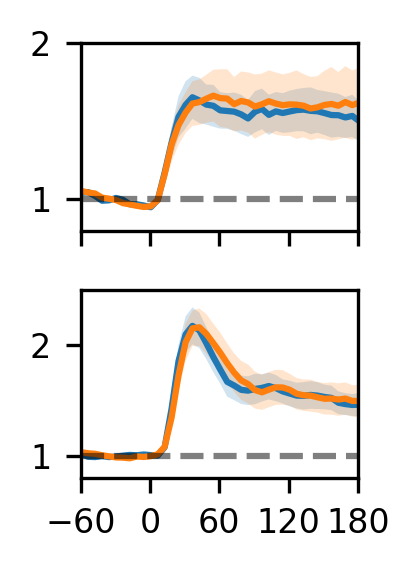

28
28


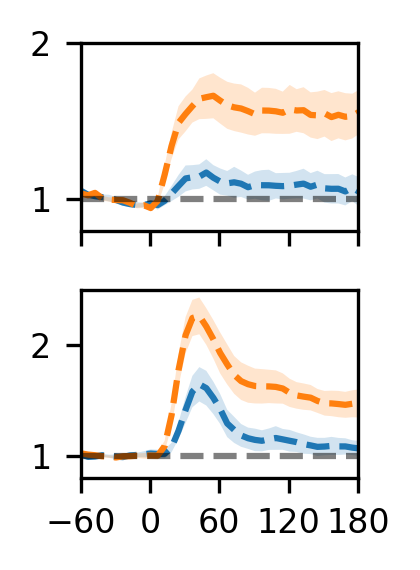

In [27]:

plt.figure(figsize = (1.5, 2), dpi = 300)

plt.subplot(211)
t = a.ch1_times[:60] - a.ch0_times[10]
L1 = np.linspace(t[10], t[40], 10)
L2 = np.linspace(t[45], t[-1], 10)

for i in [all_L1_onespot, all_L1_twospot]:
    
    print(len(i))
    m = np.nanmean(i, axis = 0)
    s = 1.96*np.nanstd(i, axis = 0)/np.sqrt(len(i))
    plt.plot(t, m)
    plt.fill_between(t, m - s, m + s, alpha = 0.2)
plt.xlim(-60, 180)
plt.ylim(0.8, 2.)
plt.yticks([1, 2], fontsize = 8)
plt.axhline(1, color = 'k', ls = '--', alpha = 0.5)
plt.xticks([-60, 0, 60, 120, 180], ['', '', '', '', ''])
#plt.fill_between(L1, 0.6, 0.7, facecolor = 'C0', alpha = 0.3)
#plt.fill_between(L2, 0.6, 0.7, facecolor = 'C0', alpha = 0.6)
#plt.ylabel('Local Pak-PBD')
#plt.xlabel('Time (s)')

plt.subplot(212)

for i in [all_L0_onespot, all_L0_twospot]:
    m = np.nanmean(i, axis = 0)
    s = 1.96*np.nanstd(i, axis = 0)/np.sqrt(len(i))
    plt.plot(t, m)
    plt.fill_between(t, m - s, m + s, alpha = 0.2)
plt.xlim(-60, 180)
plt.axhline(1, color = 'k', ls = '--', alpha = 0.5)
#plt.fill_between(L1, 0.6, 0.7, facecolor = 'C0', alpha = 0.3)
#plt.fill_between(L2, 0.6, 0.7, facecolor = 'C0', alpha = 0.6)
#plt.ylabel('Local PHAkt')
#plt.xlabel('Time (s)')
plt.xticks([-60, 0, 60, 120, 180], fontsize = 8)
plt.ylim(0.8, 2.5)
plt.yticks([1, 2], fontsize = 8)
plt.tight_layout()
plt.show()




plt.figure(figsize = (1.5, 2), dpi = 300)

plt.subplot(211)
t = a.ch1_times[:60] - a.ch0_times[10]
L1 = np.linspace(t[10], t[40], 10)
L2 = np.linspace(t[45], t[-1], 10)

for i in [all_R1_onespot, all_R1_twospot]:
    
    print(len(i))
    m = np.nanmean(i, axis = 0)
    s = 1.96*np.nanstd(i, axis = 0)/np.sqrt(len(i))
    plt.plot(t, m, ls = '--')
    plt.fill_between(t, m - s, m + s, alpha = 0.2)
plt.xlim(-60, 180)
plt.ylim(0.8, 2.)
plt.yticks([1, 2], fontsize = 8)
plt.axhline(1, color = 'k', ls = '--', alpha = 0.5)
plt.xticks([-60, 0, 60, 120, 180], ['', '', '', '', ''])
#plt.fill_between(L1, 0.6, 0.7, facecolor = 'C0', alpha = 0.3)
#plt.fill_between(L2, 0.6, 0.7, facecolor = 'C0', alpha = 0.6)
#plt.ylabel('Local Pak-PBD')
#plt.xlabel('Time (s)')

plt.subplot(212)

for i in [all_R0_onespot, all_R0_twospot]:
    m = np.nanmean(i, axis = 0)
    s = 1.96*np.nanstd(i, axis = 0)/np.sqrt(len(i))
    plt.plot(t, m, ls = '--')
    plt.fill_between(t, m - s, m + s, alpha = 0.2)
plt.xlim(-60, 180)
plt.axhline(1, color = 'k', ls = '--', alpha = 0.5)
#plt.fill_between(L1, 0.6, 0.7, facecolor = 'C0', alpha = 0.3)
#plt.fill_between(L2, 0.6, 0.7, facecolor = 'C0', alpha = 0.6)
#plt.ylabel('Local PHAkt')
#plt.xlabel('Time (s)')
plt.xticks([-60, 0, 60, 120, 180], fontsize = 8)
plt.ylim(0.8, 2.5)
plt.yticks([1, 2], fontsize = 8)
plt.tight_layout()
plt.show()


Run permutation tests to evaluate how different the averages are for each class.
These may be slightly different each time, but should be very close to reported values in the paper

Channel 0: Rac data


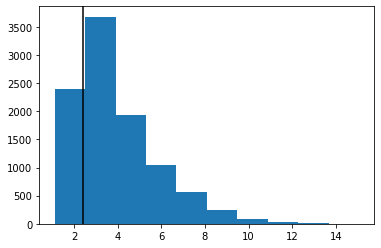

p value
0.7929
Channel 1: Pip data


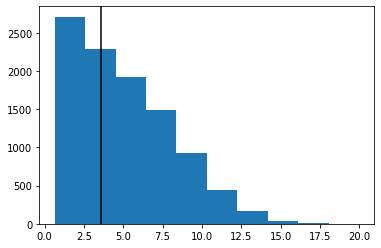

0.6097


In [38]:
print('Channel 0: Rac data')
combined_data = np.vstack([all_L0_onespot, all_L0_twospot])

sample_a = np.nanmean(combined_data[:len(all_L0_onespot)], axis = 0)
sample_b = np.nanmean(combined_data[len(all_L0_onespot):], axis = 0)
sumstat_true = np.sum(np.abs(sample_a - sample_b))

np.random.seed(0)

permuted_sumstats = []
for sim in range(10000):
    permutation = np.random.permutation(len(combined_data))
    permuted_data = combined_data[permutation]
    sample_a = np.nanmean(permuted_data[:len(all_L0_onespot)], axis = 0)
    sample_b = np.nanmean(permuted_data[len(all_L0_onespot):], axis = 0)
    sumstat = np.sum(np.abs(sample_a - sample_b))
    permuted_sumstats.append(sumstat)

plt.hist(permuted_sumstats)
plt.axvline(sumstat_true, color = 'k')
plt.show()

print('p value')
print(np.sum(np.array(permuted_sumstats) > sumstat_true)/len(permuted_sumstats))

print('Channel 1: Pip data')
combined_data = np.vstack([all_L1_onespot, all_L1_twospot])

sample_a = np.nanmean(combined_data[:len(all_L1_onespot)], axis = 0)
sample_b = np.nanmean(combined_data[len(all_L1_onespot):], axis = 0)
sumstat_true = np.sum(np.abs(sample_a - sample_b))

np.random.seed(0)

permuted_sumstats = []
for sim in range(10000):
    permutation = np.random.permutation(len(combined_data))
    permuted_data = combined_data[permutation]
    sample_a = np.nanmean(permuted_data[:len(all_L1_onespot)], axis = 0)
    sample_b = np.nanmean(permuted_data[len(all_L1_onespot):], axis = 0)
    sumstat = np.sum(np.abs(sample_a - sample_b))
    permuted_sumstats.append(sumstat)

plt.hist(permuted_sumstats)
plt.axvline(sumstat_true, color = 'k')
plt.show()

print(np.sum(np.array(permuted_sumstats) > sumstat_true)/len(permuted_sumstats))

Channel 0: Rac data


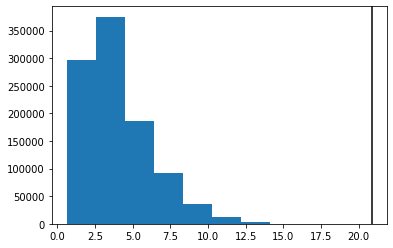

p value
0.0
Channel 1: Pip data


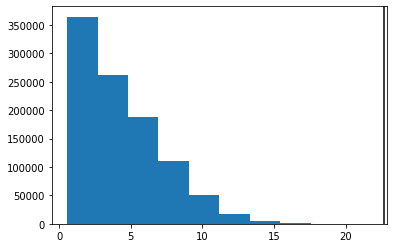

0.0


In [39]:
print('Channel 0: Rac data')
combined_data = np.vstack([all_R0_onespot, all_R0_twospot])

sample_a = np.nanmean(combined_data[:len(all_R0_onespot)], axis = 0)
sample_b = np.nanmean(combined_data[len(all_R0_onespot):], axis = 0)
sumstat_true = np.sum(np.abs(sample_a - sample_b))

np.random.seed(0)

permuted_sumstats = []
for sim in range(1000000):
    permutation = np.random.permutation(len(combined_data))
    permuted_data = combined_data[permutation]
    sample_a = np.nanmean(permuted_data[:len(all_L0_onespot)], axis = 0)
    sample_b = np.nanmean(permuted_data[len(all_L0_onespot):], axis = 0)
    sumstat = np.sum(np.abs(sample_a - sample_b))
    permuted_sumstats.append(sumstat)

plt.hist(permuted_sumstats)
plt.axvline(sumstat_true, color = 'k')
plt.show()

print('p value')
print(np.sum(np.array(permuted_sumstats) > sumstat_true)/len(permuted_sumstats))

print('Channel 1: Pip data')
combined_data = np.vstack([all_R1_onespot, all_R1_twospot])

sample_a = np.nanmean(combined_data[:len(all_R1_onespot)], axis = 0)
sample_b = np.nanmean(combined_data[len(all_R1_onespot):], axis = 0)
sumstat_true = np.sum(np.abs(sample_a - sample_b))

np.random.seed(0)

permuted_sumstats = []
for sim in range(1000000):
    permutation = np.random.permutation(len(combined_data))
    permuted_data = combined_data[permutation]
    sample_a = np.nanmean(permuted_data[:len(all_L1_onespot)], axis = 0)
    sample_b = np.nanmean(permuted_data[len(all_L1_onespot):], axis = 0)
    sumstat = np.sum(np.abs(sample_a - sample_b))
    permuted_sumstats.append(sumstat)

plt.hist(permuted_sumstats)
plt.axvline(sumstat_true, color = 'k')
plt.show()

print(np.sum(np.array(permuted_sumstats) > sumstat_true)/len(permuted_sumstats))

In [40]:
1/1000000.

1e-06

# Figure 3D

Problem with LED metadata


/tmp/ipykernel_247289/3280630583.py:11: UserWarning: No contour levels were found within the data range.
  plt.contour(light_reflected_bin, levels = [False], colors = 'C0', linestyles = '--')


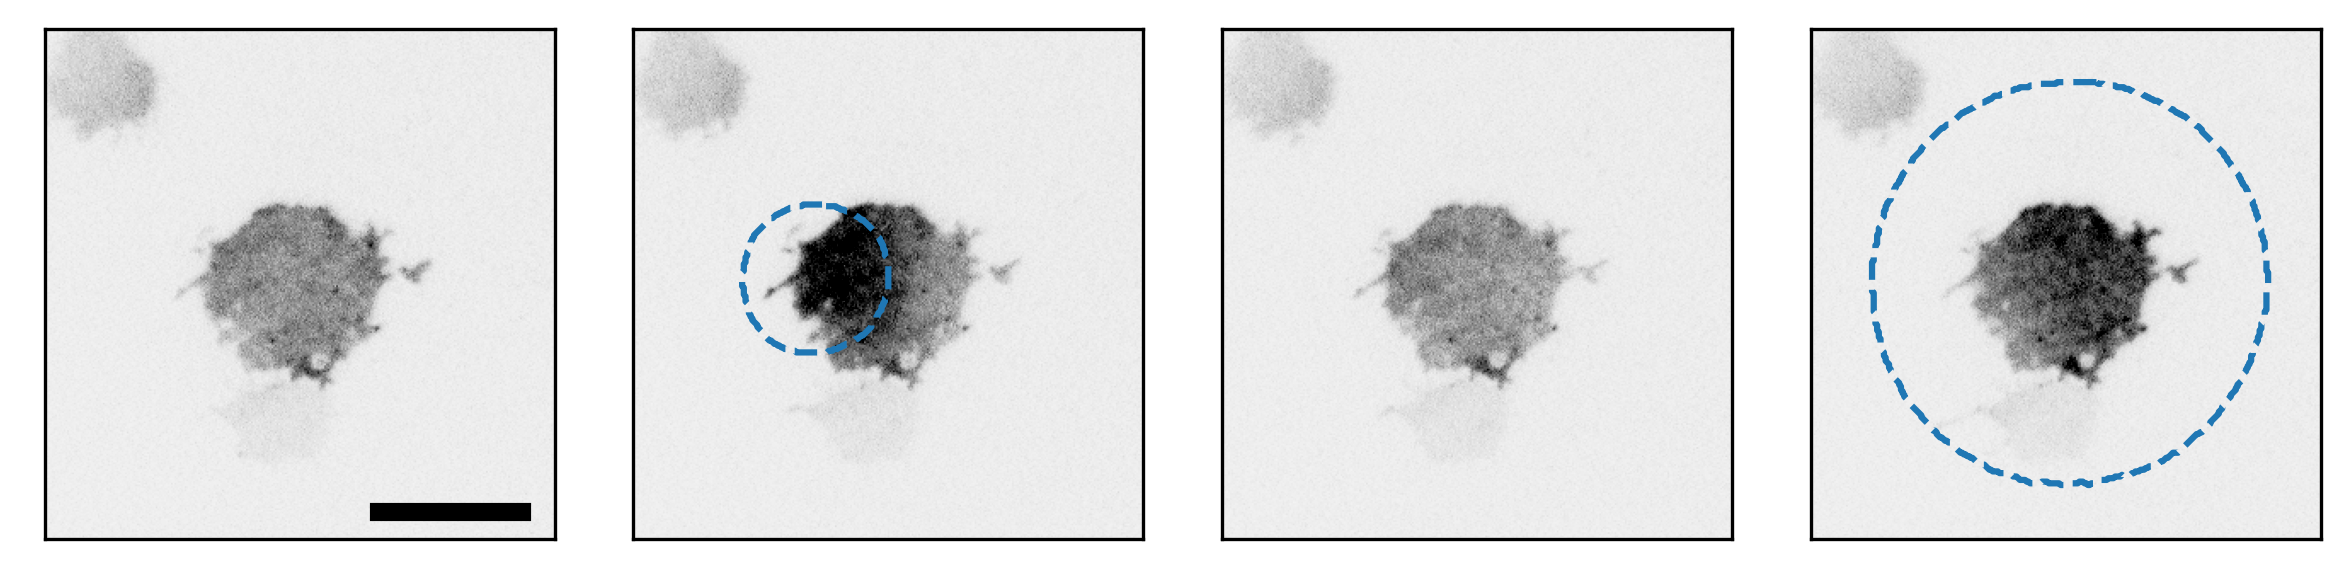

In [41]:
mma = mm_acquisition('data/fig3data/211012_KWC_35-52-97-mcPAK_undiff_10uMLatB_localAdaptationTest_14/Default/')

plt.figure(figsize = (8, 2), dpi = 300)
for i, t in enumerate([0, 20, 60, 73]):
    et = np.round(mma.elapsedtimes[mma.channels == 0][t])
    ax = plt.subplot(1, 4, i + 1, aspect = 'equal')
    plt.imshow(mma.ch0_stack[t, 400:700, 450:750], vmin = 0, vmax = 3500, cmap= 'Greys')#cmap = 'RdYlBu_r')
    light_reflected_im = mma.ch1_stack_bgcorrected[t, 400:700, 450:750]
    light_reflected_im = filters.gaussian(light_reflected_im, 2, preserve_range = True)
    light_reflected_bin = light_reflected_im > 500
    plt.contour(light_reflected_bin, levels = [False], colors = 'C0', linestyles = '--')
    plt.xticks([])
    plt.yticks([])
    pix_size = mma.microscope_image_list[0].pixelsizeum
    if i == 0:
        scalebar = mp.Rectangle((15, 280), 20/pix_size, 8, color = 'k')
        ax.add_patch(scalebar)
        #ax.text(15 + 10/pix_size, 275, '20 µm', ha = 'center', va = 'bottom', fontweight = 'bold', color = 'k')
    #ax.text(290, 290, str(et) + ' s', ha = 'right', va = 'bottom', fontweight = 'bold', color = 'w')
    plt.axis([300, 0, 300, 0])
plt.tight_layout()
plt.show()

In [42]:
CONDITION = '_frontToGlobal_'

frontToGlobalpaths = []

path = 'data/fig3data/frontToGlobal/'
for i in os.listdir(path):
    if CONDITION in i:
        frontToGlobalpaths.append(path + i)
        
print(len(frontToGlobalpaths))

26


In [43]:
all_L0 = []
all_L1 = []
all_R0 = []
all_R1 = []

for i in frontToGlobalpaths:

    print(i)
    a = simpleStimData(i)
    a.calculate_global_dynamics()
    ch0_norm = a.ch0_dynamics/np.average(a.ch0_dynamics[:10])
    ch1_norm = a.ch1_dynamics/np.average(a.ch1_dynamics[:10])

    if (np.average(ch0_norm) > 1.) and (np.average(ch1_norm) > 1.):

        yy, xx = np.where(a.ch3_stack[9])
        L_xx = xx[xx < 200]
        L_yy = yy[xx < 200]
        R_xx = xx[xx > 200]
        R_yy = yy[xx > 200]

        L0 = np.array([np.average(a.ch0_stack[T][L_yy, L_xx] - a.ch0_estimated_bg[L_yy, L_xx]) for T in range(60)])
        L1 = np.array([np.average(a.ch1_stack[T][L_yy, L_xx] - a.ch1_estimated_bg[L_yy, L_xx]) for T in range(60)])
        R0 = np.array([np.average(a.ch0_stack[T][R_yy, R_xx] - a.ch0_estimated_bg[R_yy, R_xx]) for T in range(60)])
        R1 = np.array([np.average(a.ch1_stack[T][R_yy, R_xx] - a.ch1_estimated_bg[R_yy, R_xx]) for T in range(60)])

        G0 = np.array([np.average(a.ch0_stack[T][yy, xx] - a.ch0_estimated_bg[yy, xx]) for T in range(60)])
        G1 = np.array([np.average(a.ch1_stack[T][yy, xx] - a.ch1_estimated_bg[yy, xx]) for T in range(60)])

        L0 /= np.average(L0[:10])
        L1 /= np.average(L1[:10])
        R0 /= np.average(R0[:10])
        R1 /= np.average(R1[:10])

        all_L0.append(L0)
        all_L1.append(L1)
        all_R0.append(R0)
        all_R1.append(R1)

all_L0 = np.array(all_L0)
all_L1 = np.array(all_L1)
all_R0 = np.array(all_R0)
all_R1 = np.array(all_R1)



data/fig3data/frontToGlobal/230425_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToGlobal_50000_Intensity_002


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


data/fig3data/frontToGlobal/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToGlobal_20000_Intensity_011
data/fig3data/frontToGlobal/230501_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToGlobal_60000_Intensity_001
data/fig3data/frontToGlobal/230501_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToGlobal_60000_Intensity_007
data/fig3data/frontToGlobal/230501_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToGlobal_60000_Intensity_006
data/fig3data/frontToGlobal/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToGlobal_20000_Intensity_002
data/fig3data/frontToGlobal/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToGlobal_20000_Intensity_008
data/fig3data/frontToGlobal/230425_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToGlobal_50000_Intensity_003
data/fig3data/frontToGlobal/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToGlobal_20000_Intensity_010
data/fig3data/frontToGlobal/230425_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_frontToG

23


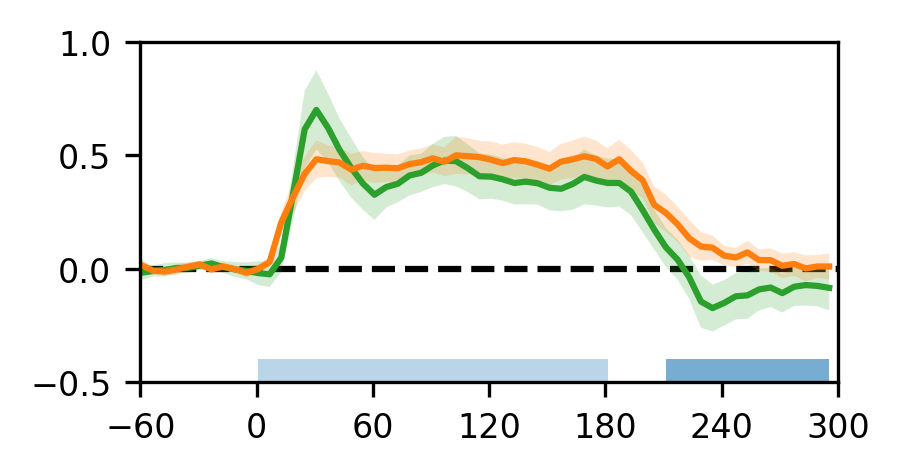

In [44]:
plt.figure(figsize = (3, 1.5), dpi = 300)


t = a.ch1_times[:60] - a.ch0_times[10]
L1 = np.linspace(t[10], t[40], 10)
L2 = np.linspace(t[45], t[-1], 10)

A = np.nanmean([all_L0[i] - all_R0[i] for i in range(len(all_L0))], axis = 0)
B = np.nanmean([all_L1[i] - all_R1[i] for i in range(len(all_L0))], axis = 0)
SA =  1.96 * np.nanstd([all_L0[i] - all_R0[i] for i in range(len(all_L0))], axis = 0)/np.sqrt(len(all_L0))
SB =  1.96 * np.nanstd([all_L1[i] - all_R1[i] for i in range(len(all_L0))], axis = 0)/np.sqrt(len(all_L0))


plt.plot(t, A, color = 'C2')
plt.fill_between(t, A - SA, A + SA, alpha = 0.2, facecolor = 'C2')
plt.plot(t, B, color = 'C1')
plt.fill_between(t, B - SB, B + SB, alpha = 0.2, facecolor = 'C1')
plt.axhline(0, color = 'k', ls = '--', zorder = -1)
plt.axis([-60, 300, -0.5, 1])

plt.fill_between(L1, -0.5, -0.4, facecolor = 'C0', alpha = 0.3)
plt.fill_between(L2, -0.5, -0.4, facecolor = 'C0', alpha = 0.6)
plt.xticks([-60, 0, 60, 120, 180, 240, 300 ], fontsize = 8)
plt.yticks(fontsize = 8)

print(len(all_L0))